# Bioinformatics 575 Group Project


***Lung Cancer Subtypes***

### Task 1 - Load the Data

In [179]:
#install GEOparse to load data set
#pip install GEOparse

In [180]:
#Access lung cancer data
#Link to data file: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245

In [181]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE10245", destdir="./")

06-Dec-2023 14:14:48 DEBUG utils - Directory ./ already exists. Skipping.
06-Dec-2023 14:14:48 INFO GEOparse - File already exist: using local version.
06-Dec-2023 14:14:48 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
06-Dec-2023 14:14:48 DEBUG GEOparse - DATABASE: GeoMiame
06-Dec-2023 14:14:48 DEBUG GEOparse - SERIES: GSE10245
06-Dec-2023 14:14:48 DEBUG GEOparse - PLATFORM: GPL570
/Users/xinli/anaconda3/lib/python3.11/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258551
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258552
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258553
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258554
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258555
06-Dec-2023 14:14:49 DEBUG GEOparse - SAMPLE: GSM258556
06-Dec-2023 14:14:49 DEBUG GEOpars

In [182]:
# sklearn.cluster module link: https://scikit-learn.org/stable/modules/clustering.html#k-means
# K-Means Algorithm link: https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_clustering_algorithms_k_means.htm

In [183]:
import pandas as pd
data = gse.pivot_samples('VALUE')
df = data.T

### Task 2 - Perform clustering via sklearn.cluster module 

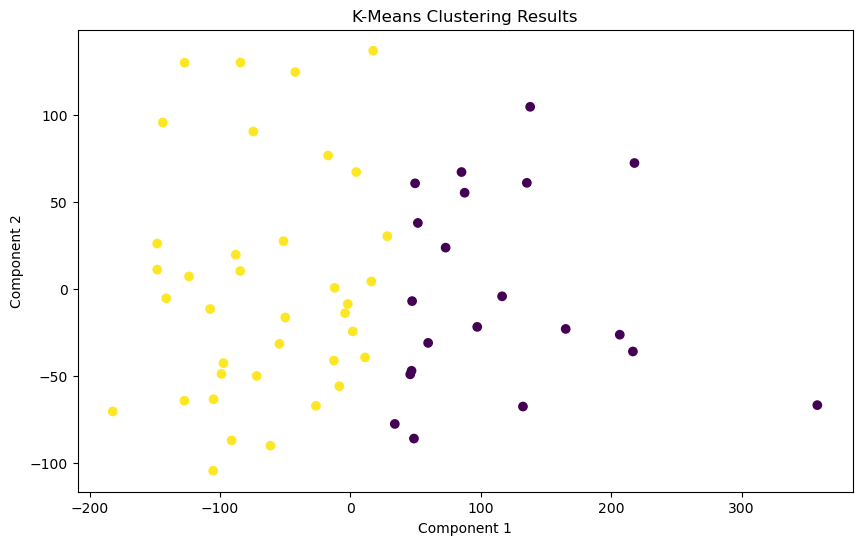

In [184]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# optional for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
#plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')

plt.title("K-Means Clustering Results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Task 3 - Dataframe Creation

In [185]:
df["cluster"] = cluster_labels
subtypes = []
for sample_id, sample in gse.gsms.items():
    #print(sample.metadata)
    subtype_info = sample.metadata.get('characteristics_ch1', [''])[0]
    # Process the subtype_info to extract the actual subtype
    # This might involve string parsing if the information is in a specific format
    subtypes.append([sample_id, subtype_info.replace("disease state: ","")])
subtypes_df = pd.DataFrame(subtypes, columns=['Name', 'Type'])
subtypes_df.set_index('Name', inplace=True)
merge_df = pd.merge(subtypes_df, df, left_index=True, right_index=True)
cluster_df = merge_df[['Type', 'cluster']]
cluster_df.head()

,Type,cluster
Name,,
GSM258551,adenocarcinoma,0
GSM258552,adenocarcinoma,1
GSM258553,squamous cell carcinoma,0
GSM258554,adenocarcinoma,0
GSM258555,squamous cell carcinoma,1


### Task 4 - Compute and display the accuracy of the clustering

In [186]:
from sklearn.metrics import confusion_matrix, accuracy_score

cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})
conf_matrix = confusion_matrix(cluster_df['Type'], cluster_df['Predicted_Label'])

accuracy = accuracy_score(cluster_df['Type'], cluster_df['Predicted_Label'])
#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)

Accuracy: 0.5344827586206896


/var/folders/rx/ny1j8gd54cbc25g248twqkb40000gn/T/ipykernel_85770/1752634035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df.loc[:, 'Predicted_Label'] = cluster_df['cluster'].map({1: 'adenocarcinoma', 0: 'squamous cell carcinoma'})


### Task 5 - Fit the model on half of the data predict the cluster for the other half

In [187]:


from sklearn.model_selection import train_test_split

# get original data of df in question 1
expression_df = df.drop(columns=["cluster"])
subtype_df = subtypes_df

# Merging the expression data with subtype information
merged_df = pd.merge(expression_df, subtype_df, left_on='name', right_on='Name')

# Splitting the data into adenocarcinoma (AD) and squamous cell carcinoma (SCC)
ad_df = merged_df[merged_df["Type"] == "adenocarcinoma"]
scc_df = merged_df[merged_df["Type"] == "squamous cell carcinoma"]

# Splitting each subtype into two halves for training and testing
ad_train, ad_test = train_test_split(ad_df, test_size=0.5, random_state=42)
scc_train, scc_test = train_test_split(scc_df, test_size=0.5, random_state=42)

# Combining the halves to create training and testing datasets
train_df = pd.concat([ad_train, scc_train])
test_df = pd.concat([ad_test, scc_test])

# DataFrame containing training data, excluding the "Type" column
X_train = train_df.drop(columns=["Type"])

# Training the KMeans model on the first half of the data
kmeans_train = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_train.fit(X_train)

# Preparing the test data (features only)
X_test = test_df.drop(columns=["Type"])

# Predicting the cluster labels for the second half
test_cluster_labels = kmeans_train.predict(X_test)



### Task 6 - Compute and display the accuracy of the model for the prediction results

In [188]:

# Mapping cluster numbers to subtype labels. Just like question 4
train_df['cluster'] = kmeans_train.labels_

# Finding the most common subtype for each cluster
cluster_0_subtype = train_df[train_df['cluster'] == 0]['Type'].mode()[0] 
cluster_1_subtype = train_df[train_df['cluster'] == 1]['Type'].mode()[0]

# Mapping cluster numbers to subtype labels for the test data
test_predicted_labels = pd.Series(test_cluster_labels).map({0: cluster_0_subtype, 1: cluster_1_subtype})

# Evaluating the performance on the test data. Just like question 4
test_accuracy = accuracy_score(test_df["Type"], test_predicted_labels)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9655172413793104


### Part 7 - Plot (bar plot) the 3 accuracy values for the model

In [189]:
# (i) train the model on all the data and compute the accuracy of the model on that data
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

X_all = merged_df.drop(columns=["Type"])

kmeans_all = KMeans(n_clusters=2, n_init=10, random_state=42)
#Kmeans analysis
kmeans_all.fit(X_all)
#Assign cluster labels
merged_df['cluster'] = kmeans_all.labels_

#Find most common subtype - see part 5 
cluster_0_subtype_all = merged_df[merged_df['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_all = merged_df[merged_df['cluster'] == 1]['Type'].mode()[0]

#Cluster labels from KMeans model mapped to predicted subtypes
all_predicted_labels = pd.Series(kmeans_all.labels_).map({0: cluster_0_subtype_all, 1: cluster_1_subtype_all})

#Compute accuracy
accuracy_all = accuracy_score(merged_df["Type"], all_predicted_labels)
print("Accuracy on All Data:", accuracy_all)

# (ii) train the model on half of the data and compute the accuracy of the model on that data

df_task7, _ = train_test_split(merged_df, test_size=0.5, random_state=42)
X_train_task7 = df_task7.drop(columns=["Type"])

kmeans_train_task7 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_train_task7.fit(X_train_task7)

train_cluster_task7 = kmeans_train_task7.predict(X_train_task7)
train_df_task7 = df_task7.copy()
train_df_task7['cluster'] = kmeans_train_task7.labels_

cluster_0_subtype_task7 = train_df_task7[train_df_task7['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_task7 = train_df_task7[train_df_task7['cluster'] == 1]['Type'].mode()[0]

predicted_labels_task7 = pd.Series(train_cluster_task7).map({0: cluster_0_subtype_task7, 1: cluster_1_subtype_task7})

accuracy_task7 = accuracy_score(train_df_task7["Type"], predicted_labels_task7)
print("Accuracy on Half of the Data:", accuracy_task7)

Accuracy on All Data: 0.8793103448275862
Accuracy on Half of the Data: 0.8620689655172413


In [190]:
# (iii) compute the model accuracy built at point (ii) on the other half of the data (test data)

#Get remaining half of data set

test_df_task7 = merged_df.drop(df_task7.index)

#Get features 
X_test_task7 = test_df_task7.drop(columns=['Type'])

#Utilize trained model from i&ii to predict labels for test data (essentially the same from part ii but with 'test' data)
test_cluster_task7 = kmeans_train_task7.predict(X_test_task7)
test_df_task7 = test_df_task7.copy() #Avoid motifying original datafram directly
test_df_task7['cluster'] = test_cluster_task7 #predicted labels added as new column

#Map cluster labels to subtype labels 

cluster_0_subtype_test_task7 = test_df_task7[test_df_task7['cluster'] == 0]['Type'].mode()[0]
cluster_1_subtype_test_task7 = test_df_task7[test_df_task7['cluster'] == 1]['Type'].mode()[0]

#Assign predicted cluster labels to subtype labels

predicted_labels_test_task7 = pd.Series(test_cluster_task7).map({
    0: cluster_0_subtype_test_task7, 
    1: cluster_1_subtype_test_task7
})

#Compute accuracy 
accuracy_test_task7 = accuracy_score(test_df_task7["Type"], predicted_labels_test_task7)
print("Accuracy on the Other Half of the Data (Test Data):", accuracy_test_task7)

Accuracy on the Other Half of the Data (Test Data): 0.896551724137931


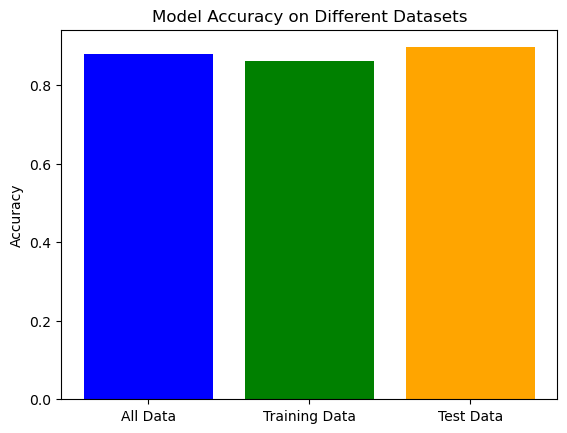

In [191]:
#Plot accuracies 
accuracies = [accuracy_all, accuracy_task7, accuracy_test_task7]
labels = ['All Data', 'Training Data', 'Test Data']

plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Different Datasets')
plt.show()

### Task 8.1- What are the top differentailly expressed genes in two types of tumor from the dataset?

In [192]:
# data breakdown
# seperate the data into 2 dataframe without removing any information, each of them represent one type of tumor group


# merge original df in question 1 with type column
df_with_type = pd.merge(subtypes_df, df, left_index=True, right_index=True)
df_with_type = df_with_type.drop('cluster', axis=1)

# Splitting the data into adenocarcinoma (AD) and squamous cell carcinoma (SCC)
ad_df_type = df_with_type[df_with_type["Type"] == "adenocarcinoma"]
scc_df_type = df_with_type[df_with_type["Type"] == "squamous cell carcinoma"]



In [193]:
# Calculate mean expression levels for each gene in both groups
scc_df_type =scc_df_type.drop('Type', axis=1)
ad_df_type  =ad_df_type.drop('Type', axis=1)
ad_mean = ad_df_type.mean()
scc_mean = scc_df_type.mean()

# Calculate fold change (SCC/AD)
fold_change = scc_mean / ad_mean


In [194]:
import scipy.stats as stats
import numpy as np

# Perform t-tests for each gene
p_values = [stats.ttest_ind(ad_df_type[gene], scc_df_type[gene], nan_policy='omit').pvalue for gene in ad_df_type.columns]

# Adjust p-values for multiple comparisons (FDR)
from statsmodels.stats.multitest import multipletests
_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'Probe ID': ad_df_type.columns,
    'Fold Change': fold_change,
    'Adjusted P-Value': p_adjusted
})



In [195]:
#To convert probe ID into gene symbol
#Dowload family file and extract probe ID-gene symbol information
import requests
import gzip
import tarfile
import pandas as pd
from io import BytesIO

# Download the file in chunks
url = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE10nnn/GSE10245/miniml/GSE10245_family.xml.tgz'
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open('GSE10245_family.xml.tgz', 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Unzip the .tgz file
with gzip.open('GSE10245_family.xml.tgz') as f:
    with tarfile.open(fileobj=f) as tar:
        tar.extractall("extracted_files")
file_path = 'extracted_files/GPL570-tbl-1.txt'  # Adjust the path
df_mapping = pd.read_csv(file_path, sep='\t', usecols=[0, 10])
df_mapping.columns = ['Probe ID', 'Gene Symbol']
df_mapping.dropna(subset=['Probe ID', 'Gene Symbol'], inplace=True)

In [196]:
#To annotate gene and get top 50 high/low expression gene
merged_df = pd.merge(results_df, df_mapping, how='left', left_on='Probe ID', right_on='Probe ID')
High_express50 = merged_df.sort_values(by='Fold Change', ascending=False).head(50)
Low_express50 = merged_df.sort_values(by='Fold Change', ascending=True).head(50)

In [197]:
Low_express50.head()

,Probe ID,Fold Change,Adjusted P-Value,Gene Symbol
16200,206754_s_at,0.442469,4.475015e-05,CYP2B6 /// CYP2B7P
38284,229030_at,0.450836,3.250906e-08,CAPN8
31008,221728_x_at,0.453420,4.697510e-02,XIST
33847,224588_at,0.459131,5.022415e-02,XIST
38626,229372_at,0.459731,3.093836e-07,GOLT1A


### Task 8.2- Visualize the differentailly expressed genes

In [198]:
#Visualization using seaborn library 
#pip install seaborn matplotlib

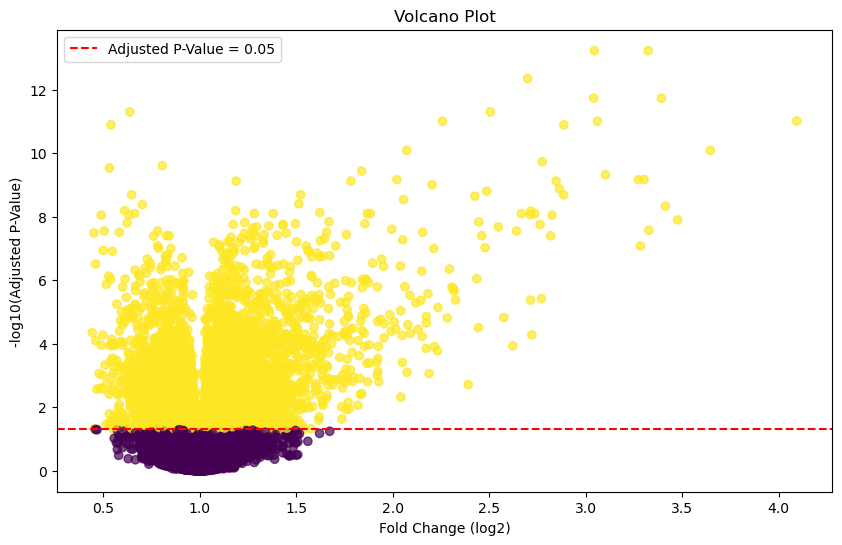

In [199]:
#Volcano Plot for Visualization of differentailly expressed genes
import matplotlib.pyplot as plt

# Set the significance threshold
alpha = 0.05

# Create a boolean mask for significant genes based on adjusted p-value, basically used to color the points based on where they fall
significant_genes = merged_df['Adjusted P-Value'] < alpha

# Plot volcano plot

#Set figure size
plt.figure(figsize=(10, 6))

#Use Fold Change to make X axis and Adjusted P values to make Y axis, logs used to visualize the small P values
plt.scatter(merged_df['Fold Change'], -np.log10(merged_df['Adjusted P-Value']), c=significant_genes, cmap='viridis', alpha=0.7)

#Add titles and set colors
plt.title('Volcano Plot')
plt.xlabel('Fold Change (log2)')
plt.ylabel('-log10(Adjusted P-Value)')
plt.axhline(-np.log10(alpha), color='red', linestyle='--', label=f'Adjusted P-Value = {alpha}')
plt.legend()
plt.show()
#Volcano plot interpretation: 

    # Each point represents a gene and x-axis position indicates how much the gene's expression changes between conditions
    #Y axis is adjusted P-value 
    #Statistically significant gnes are higher up on Y axis (Yellow is significant)
    # Points in upper corners are both significantly changed and have a substantial fold change 
        # Right of center is upregulation and left is down regulation. 
            # fold_change = scc_mean / ad_mean
    
    #There are clearly a wide distribution of scc genes that are upregulated. These could be of interest for future investigations. 

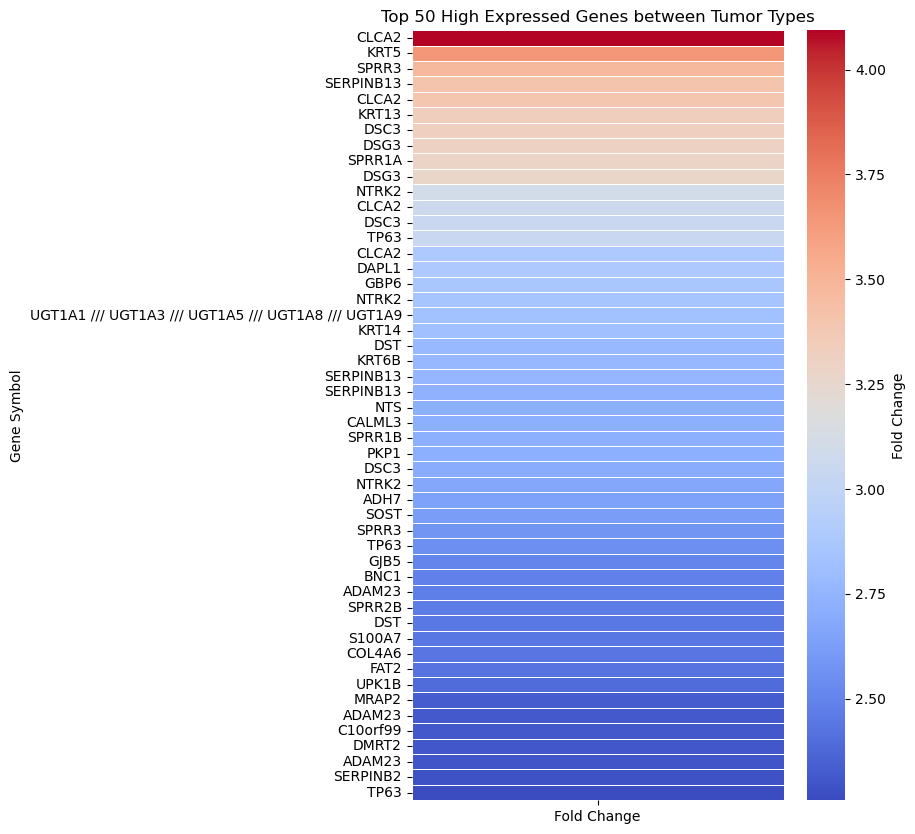

In [206]:
# Create a heatmap for the top 50 genes
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'High_express50' with the data

# Set a larger figure size
plt.figure(figsize=(6, 10))

# Create the heatmap
heatmap = sns.heatmap(
    High_express50.set_index('Gene Symbol')[['Fold Change']],
    cmap='coolwarm',
    linewidths=.5,
    annot=False,
    cbar_kws={'label': 'Fold Change'}  # Add a colorbar label
)


# Label the y-axis with 'Gene Symbol'
plt.ylabel('Gene Symbol')

# Set the title
plt.title('Top 50 High Expressed Genes between Tumor Types')

# Rotate the y-axis labels for better visibility
plt.yticks(rotation=0)

plt.show()


#Interpretation: AC = condition 1, SCC = condition 2. Fold change SCC/AD. Smaller numbers = more common in AD, larger = more common in SCC

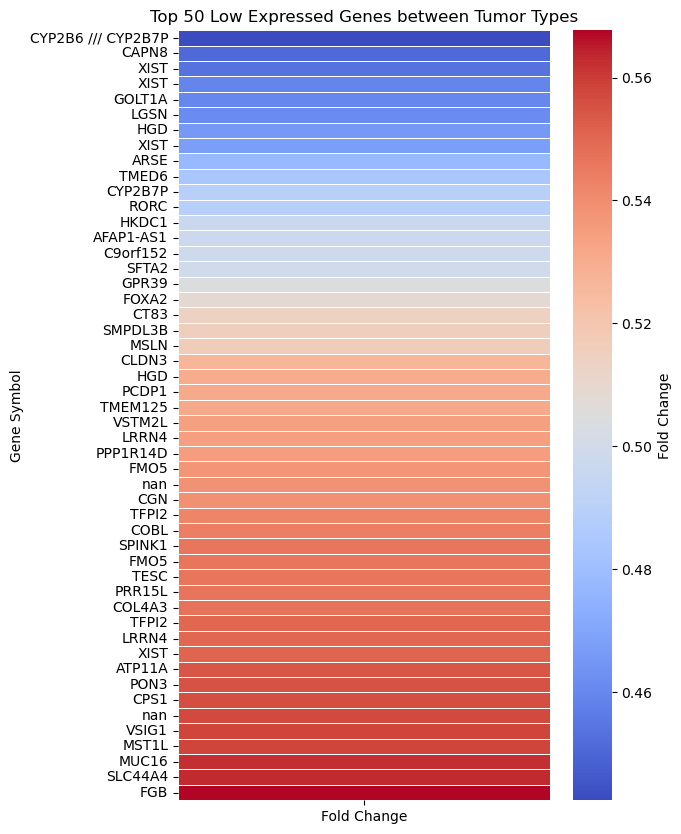

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'High_express50' with the data

# Set a larger figure size
plt.figure(figsize=(6, 10))

# Create the heatmap
heatmap = sns.heatmap(
    Low_express50.set_index('Gene Symbol')[['Fold Change']],
    cmap='coolwarm',
    linewidths=.5,
    annot=False,
    cbar_kws={'label': 'Fold Change'}  # Add a colorbar label
)


# Label the y-axis with 'Gene Symbol'
plt.ylabel('Gene Symbol')

# Set the title
plt.title('Top 50 Low Expressed Genes between Tumor Types')

# Rotate the y-axis labels for better visibility
plt.yticks(rotation=0)

plt.show()


### Task 8.3 Does top differentailly expressed genes come from same function pathway?

In [202]:
#Perform GO entichment analysis through API for high expression top 50 genes
#pip install requests

import requests
input_list = ','.join(map(str, High_express50['Gene Symbol']))
organism = "9606"  # Human
annot_data_set = "GO:0008150"  # Gene Ontology Biological Process
enrichment_test_type = "FISHER"
correction = "FDR"
url = "https://pantherdb.org/services/oai/pantherdb/enrich/overrep"
params = {
    "geneInputList": input_list,
    "organism": "9606",  # Human
    "annotDataSet": "GO:0008150",  # GO Biological Process
    "enrichmentTestType": "FISHER",
    "correction": "FDR"
}

# Make the POST request
response = requests.post(url, data=params)

# Check if the request was successful
if response.status_code == 200:
    # Process the response (the following depends on the response format)
    output_high = response.json()  # or response.json() if the response is in JSON format
else:
    print(f"Request failed with status code: {response.status_code}")


In [203]:
data =output_high['results']
df_data_high = []
for entry in data['result']:
    # Check if 'id' and 'label' keys exist in the 'term' dictionary
    term_id = entry['term']['id'] if 'id' in entry['term'] else 'N/A'
    term_label = entry['term']['label'] if 'label' in entry['term'] else 'N/A'
    
    row = [
        term_id,
        term_label,
        entry.get('number_in_list', 'N/A'),
        entry.get('fold_enrichment', 'N/A'),
        entry.get('fdr', 'N/A'),
        entry.get('expected', 'N/A'),
        entry.get('number_in_reference', 'N/A'),
        entry.get('pValue', 'N/A'),
        entry.get('plus_minus', 'N/A')
    ]
    if row[2] >= 10 and row[-2] < 0.01:
        df_data_high.append(row)

# Define DataFrame columns
df_columns = ['Term ID', 'Label', 'Number in List', 'Fold Enrichment', 'FDR', 'Expected', 'Number in Reference', 'P-Value', 'Plus/Minus']
df_highexpress_top50 = pd.DataFrame(df_data_high, columns=df_columns)
    # Check for duplicate entries before appending
df_highexpress_top50

,Term ID,Label,Number in List,Fold Enrichment,FDR,Expected,Number in Reference,P-Value,Plus/Minus
0,GO:0008544,epidermis development,11,19.261224,5.890467e-08,0.571096,336,7.586409e-12,+
1,GO:0030855,epithelial cell differentiation,11,10.256373,1.600768e-05,1.072504,631,5.154124e-09,+
2,GO:0060429,epithelium development,12,6.435838,2.501287e-04,1.864559,1097,1.449648e-07,+
3,GO:0009888,tissue development,14,4.714825,6.087739e-04,2.969357,1747,4.312263e-07,+
4,GO:0032501,multicellular organismal process,22,1.934182,3.970431e-01,11.374320,6692,3.835177e-04,+
5,GO:0030154,cell differentiation,15,2.464435,3.783306e-01,6.086587,3581,3.898055e-04,+
6,GO:0048869,cellular developmental process,15,2.448029,3.835825e-01,6.127380,3605,4.199177e-04,+
7,GO:0032502,developmental process,19,1.964935,8.361785e-01,9.669532,5689,9.692326e-04,+
8,GO:0048856,anatomical structure development,17,1.927506,1.000000e+00,8.819687,5189,2.900395e-03,+
9,GO:0009605,response to external stimulus,10,2.432174,1.000000e+00,4.111548,2419,5.740711e-03,+


In [204]:
#Perform GO entichment analysis through API for low expression top 50 genes


input_list = ','.join(map(str, Low_express50['Gene Symbol']))
organism = "9606"  # Human
annot_data_set = "GO:0008150"  # Gene Ontology Biological Process
enrichment_test_type = "FISHER"
correction = "FDR"
url = "https://pantherdb.org/services/oai/pantherdb/enrich/overrep"
params = {
    "geneInputList": input_list,
    "organism": "9606",  # Human
    "annotDataSet": "GO:0008150",  # GO Biological Process
    "enrichmentTestType": "FISHER",
    "correction": "FDR"
}

# Make the POST request
response = requests.post(url, data=params)

# Check if the request was successful
if response.status_code == 200:
    # Process the response (the following depends on the response format)
    output_low = response.json()  # or response.json() if the response is in JSON format
else:
    print(f"Request failed with status code: {response.status_code}")


In [205]:
data =output_low['results']
df_data_low = []
for entry in data['result']:
    # Check if 'id' and 'label' keys exist in the 'term' dictionary
    term_id = entry['term']['id'] if 'id' in entry['term'] else 'N/A'
    term_label = entry['term']['label'] if 'label' in entry['term'] else 'N/A'
    
    row = [
        term_id,
        term_label,
        entry.get('number_in_list', 'N/A'),
        entry.get('fold_enrichment', 'N/A'),
        entry.get('fdr', 'N/A'),
        entry.get('expected', 'N/A'),
        entry.get('number_in_reference', 'N/A'),
        entry.get('pValue', 'N/A'),
        entry.get('plus_minus', 'N/A')
    ]
    if row[2] >= 10 and row[-2] < 0.01:
        df_data_low.append(row)

# Define DataFrame columns
df_columns = ['Term ID', 'Label', 'Number in List', 'Fold Enrichment', 'FDR', 'Expected', 'Number in Reference', 'P-Value', 'Plus/Minus']
df_lowexpress_top50 = pd.DataFrame(df_data_low, columns=df_columns)
    # Check for duplicate entries before appending
df_lowexpress_top50

,Term ID,Label,Number in List,Fold Enrichment,FDR,Expected,Number in Reference,P-Value,Plus/Minus


### We found some high expression gene show enrichment in cell differentiation related process, no enrichment is found for low expression gene group